In [1]:
import re, sys, glob, io
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

randomstate = 42

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import ipywidgets as widgets

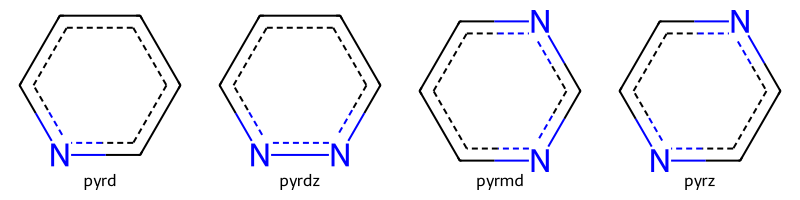

In [2]:
# we have to map to their corresponding core structures
common_structure_list = {}

common_structure_chemdraw = glob.glob("*.cdxml")
common_structure_chemdraw

for file in common_structure_chemdraw:
    # get the filename without the extension, we will use it as the prefix
    key = file.split(".")[0]
    substructure = Chem.MolsFromCDXMLFile(file)
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure

# Prepare the list of molecules and corresponding legends (for display under each molecule)
mols = list(common_structure_list.values())
legends = list(common_structure_list.keys())
# Generate a grid image with a fixed number of columns (4 columns)
img = Chem.Draw.MolsToGridImage(
    mols, molsPerRow=4, subImgSize=(200, 200), legends=legends
)
# Display the grid of images
display(img)

In [3]:
# load an excel file name smiles.xlsx
df = pd.read_excel('smiles.xlsx')
# use RDKit convert SMILES to mol object, make a dict with id as key and mol object as value
mols = {}
for i, row in df.iterrows():
    mols[row['id']] = Chem.MolFromSmiles(row['SMILES'])

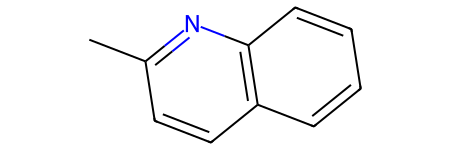

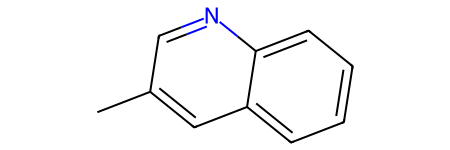

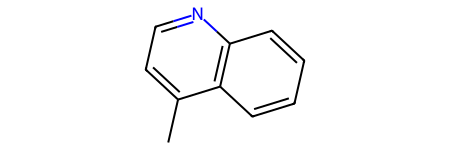

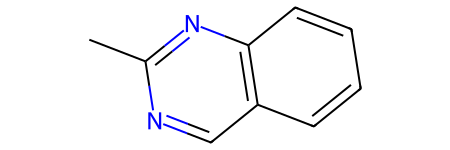

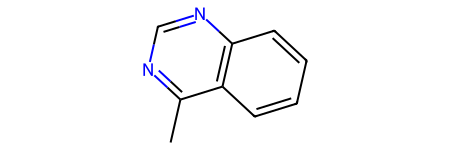

In [4]:
# display the first 5 molecules
for i, (id, mol) in enumerate(mols.items()):
    if i >= 5:
        break
    display(mol)

In [5]:
# now attempt to match all common structures to each molecule, and if we find a match, we will store into a mapping from original id to new prefix
# use GetSubstructMatches
mapping = {}
for id, mol in mols.items():
    for key, substructure in common_structure_list.items():
        if mol.HasSubstructMatch(substructure):
            # first check if this id is already in the mapping
            if id in mapping:
                print(f'{id} already in mapping, will not overwrite with {key}')
            else:
                print(f'{id} matches {key}')
                mapping[id] = key

Het001 matches pyrd
Het002 matches pyrd
Het003 matches pyrd
Het004 matches pyrmd
Het005 matches pyrmd
Het006 matches pyrz
Het007 matches pyrd
Het008 matches pyrd
Het009 matches pyrd
Het010 matches pyrd
Het011 matches pyrd
Het012 matches pyrd
Het013 matches pyrmd
Het014 matches pyrmd
Het015 matches pyrz
Het016 matches pyrd
Het017 matches pyrd
Het018 matches pyrd
Het019 matches pyrd
Het020 matches pyrd
Het021 matches pyrd
Het022 matches pyrmd
Het023 matches pyrmd
Het024 matches pyrmd
Het025 matches pyrz
Het026 matches pyrdz
Het027 matches pyrdz
Het028 matches pyrd
Het029 matches pyrd
Het030 matches pyrd
Het031 matches pyrmd
Het032 matches pyrmd
Het033 matches pyrmd
Het034 matches pyrz
Het035 matches pyrdz


In [6]:
mapping

{'Het001': 'pyrd',
 'Het002': 'pyrd',
 'Het003': 'pyrd',
 'Het004': 'pyrmd',
 'Het005': 'pyrmd',
 'Het006': 'pyrz',
 'Het007': 'pyrd',
 'Het008': 'pyrd',
 'Het009': 'pyrd',
 'Het010': 'pyrd',
 'Het011': 'pyrd',
 'Het012': 'pyrd',
 'Het013': 'pyrmd',
 'Het014': 'pyrmd',
 'Het015': 'pyrz',
 'Het016': 'pyrd',
 'Het017': 'pyrd',
 'Het018': 'pyrd',
 'Het019': 'pyrd',
 'Het020': 'pyrd',
 'Het021': 'pyrd',
 'Het022': 'pyrmd',
 'Het023': 'pyrmd',
 'Het024': 'pyrmd',
 'Het025': 'pyrz',
 'Het026': 'pyrdz',
 'Het027': 'pyrdz',
 'Het028': 'pyrd',
 'Het029': 'pyrd',
 'Het030': 'pyrd',
 'Het031': 'pyrmd',
 'Het032': 'pyrmd',
 'Het033': 'pyrmd',
 'Het034': 'pyrz',
 'Het035': 'pyrdz'}

In [7]:
# now step into to logs folder, rename the files to the new prefix
# the original file is named like Het001_conf-1.log
# the goal is to swap "Het001" to the new prefix pyrd and add a unique number to the end, in this case pyrd1
# maintain four counter starting from 1 for each prefix
# we will use the os module to rename the files

import os
import re
import shutil

final_mapping = {}

# create a new folder to store the renamed files
os.makedirs("renamed_logs", exist_ok=True)

# create a counter for each prefix
counter = {}
for key in common_structure_list.keys():
    counter[key] = 1
    
file_list = glob.glob("logs/*.log")
# sort the file list
file_list.sort()


# loop through the logs folder
for file in file_list:
    # get the filename without the extension
    filename = os.path.basename(file).split(".")[0]
    # get the prefix
    prefix = filename.split("-")[0]
    subprefix = prefix.split("_")[0]
    # store the other part of the filename
    other = filename.split("-")[1]
    # split by - get the first part, check against all key in the final_mapping
    if prefix in final_mapping:
        print(f"{prefix} already in final_mapping, will not overwrite")
        continue
    print(
        f"Processing {filename}, prefix: {prefix}, subprefix: {subprefix}, other: {other}"
    )

    # check if the subprefix is already in the final_mapping
    if subprefix not in final_mapping:
        new_filename = (
            mapping[subprefix]
            + str(counter[mapping[subprefix]])
            + "_conf-"
            + other
            + ".log"
        )
        # this mean we haven't assign a new number to this subprefix
        final_mapping[subprefix] = [new_filename]
        # increment the counter
        counter[mapping[subprefix]] += 1
    else:
        # now this subprefix is already assign a new number, we will reuse the number
        # note we will not use the counter and instead we will use regex to extract the number
        number = int(re.search(r"(\d+)_", final_mapping[subprefix][-1]).group(1))
        print(
            f"New number alreadu assigned: {number}, extract from {final_mapping[subprefix][-1]}"
        )
        new_filename = mapping[subprefix] + str(number) + "_conf-" + other + ".log"
        final_mapping[subprefix].append(new_filename)

    print(f"New filename: {new_filename}")
    print(f"Renaming {filename} to {new_filename}")
    if os.path.exists(f"renamed_logs/{new_filename}"):
        print(f"Warning: {new_filename} already exists, will overwrite")
    print("-----------------------------")
    # check if the file already exists in renamed_logs
    # copy the file with the new prefix to renamed_logs
    shutil.copy(file, f"renamed_logs/{new_filename}")

Processing Het001_conf-1, prefix: Het001_conf, subprefix: Het001, other: 1
New filename: pyrd1_conf-1.log
Renaming Het001_conf-1 to pyrd1_conf-1.log
-----------------------------
Processing Het002_conf-1, prefix: Het002_conf, subprefix: Het002, other: 1
New filename: pyrd2_conf-1.log
Renaming Het002_conf-1 to pyrd2_conf-1.log
-----------------------------
Processing Het003_conf-1, prefix: Het003_conf, subprefix: Het003, other: 1
New filename: pyrd3_conf-1.log
Renaming Het003_conf-1 to pyrd3_conf-1.log
-----------------------------
Processing Het004_conf-1, prefix: Het004_conf, subprefix: Het004, other: 1
New filename: pyrmd1_conf-1.log
Renaming Het004_conf-1 to pyrmd1_conf-1.log
-----------------------------
Processing Het005_conf-1, prefix: Het005_conf, subprefix: Het005, other: 1
New filename: pyrmd2_conf-1.log
Renaming Het005_conf-1 to pyrmd2_conf-1.log
-----------------------------
Processing Het006_conf-1, prefix: Het006_conf, subprefix: Het006, other: 1
New filename: pyrz1_conf-1

In [8]:
final_mapping

{'Het001': ['pyrd1_conf-1.log'],
 'Het002': ['pyrd2_conf-1.log'],
 'Het003': ['pyrd3_conf-1.log'],
 'Het004': ['pyrmd1_conf-1.log'],
 'Het005': ['pyrmd2_conf-1.log'],
 'Het006': ['pyrz1_conf-1.log'],
 'Het007': ['pyrd4_conf-1.log'],
 'Het008': ['pyrd5_conf-1.log'],
 'Het009': ['pyrd6_conf-1.log'],
 'Het010': ['pyrd7_conf-1.log', 'pyrd7_conf-2.log', 'pyrd7_conf-3.log'],
 'Het011': ['pyrd8_conf-1.log', 'pyrd8_conf-2.log'],
 'Het012': ['pyrd9_conf-1.log', 'pyrd9_conf-2.log'],
 'Het013': ['pyrmd3_conf-1.log', 'pyrmd3_conf-2.log'],
 'Het014': ['pyrmd4_conf-1.log', 'pyrmd4_conf-2.log'],
 'Het015': ['pyrz2_conf-1.log', 'pyrz2_conf-2.log', 'pyrz2_conf-3.log'],
 'Het016': ['pyrd10_conf-1.log', 'pyrd10_conf-2.log'],
 'Het017': ['pyrd11_conf-1.log'],
 'Het018': ['pyrd12_conf-1.log', 'pyrd12_conf-2.log'],
 'Het019': ['pyrd13_conf-1.log'],
 'Het020': ['pyrd14_conf-1.log'],
 'Het021': ['pyrd15_conf-1.log'],
 'Het022': ['pyrmd5_conf-1.log'],
 'Het023': ['pyrmd6_conf-1.log'],
 'Het024': ['pyrmd7_conf-

In [9]:
# sort the final_mapping by the key, use the number in the prefix, format is Het008, split by Het and get the numerical part and turn it into integer
sorted_mapping = dict(
    sorted(final_mapping.items(), key=lambda x: int(x[0].split("Het")[1]))
)

In [10]:
sorted_mapping

{'Het001': ['pyrd1_conf-1.log'],
 'Het002': ['pyrd2_conf-1.log'],
 'Het003': ['pyrd3_conf-1.log'],
 'Het004': ['pyrmd1_conf-1.log'],
 'Het005': ['pyrmd2_conf-1.log'],
 'Het006': ['pyrz1_conf-1.log'],
 'Het007': ['pyrd4_conf-1.log'],
 'Het008': ['pyrd5_conf-1.log'],
 'Het009': ['pyrd6_conf-1.log'],
 'Het010': ['pyrd7_conf-1.log', 'pyrd7_conf-2.log', 'pyrd7_conf-3.log'],
 'Het011': ['pyrd8_conf-1.log', 'pyrd8_conf-2.log'],
 'Het012': ['pyrd9_conf-1.log', 'pyrd9_conf-2.log'],
 'Het013': ['pyrmd3_conf-1.log', 'pyrmd3_conf-2.log'],
 'Het014': ['pyrmd4_conf-1.log', 'pyrmd4_conf-2.log'],
 'Het015': ['pyrz2_conf-1.log', 'pyrz2_conf-2.log', 'pyrz2_conf-3.log'],
 'Het016': ['pyrd10_conf-1.log', 'pyrd10_conf-2.log'],
 'Het017': ['pyrd11_conf-1.log'],
 'Het018': ['pyrd12_conf-1.log', 'pyrd12_conf-2.log'],
 'Het019': ['pyrd13_conf-1.log'],
 'Het020': ['pyrd14_conf-1.log'],
 'Het021': ['pyrd15_conf-1.log'],
 'Het022': ['pyrmd5_conf-1.log'],
 'Het023': ['pyrmd6_conf-1.log'],
 'Het024': ['pyrmd7_conf-

In [11]:
mapping

{'Het001': 'pyrd',
 'Het002': 'pyrd',
 'Het003': 'pyrd',
 'Het004': 'pyrmd',
 'Het005': 'pyrmd',
 'Het006': 'pyrz',
 'Het007': 'pyrd',
 'Het008': 'pyrd',
 'Het009': 'pyrd',
 'Het010': 'pyrd',
 'Het011': 'pyrd',
 'Het012': 'pyrd',
 'Het013': 'pyrmd',
 'Het014': 'pyrmd',
 'Het015': 'pyrz',
 'Het016': 'pyrd',
 'Het017': 'pyrd',
 'Het018': 'pyrd',
 'Het019': 'pyrd',
 'Het020': 'pyrd',
 'Het021': 'pyrd',
 'Het022': 'pyrmd',
 'Het023': 'pyrmd',
 'Het024': 'pyrmd',
 'Het025': 'pyrz',
 'Het026': 'pyrdz',
 'Het027': 'pyrdz',
 'Het028': 'pyrd',
 'Het029': 'pyrd',
 'Het030': 'pyrd',
 'Het031': 'pyrmd',
 'Het032': 'pyrmd',
 'Het033': 'pyrmd',
 'Het034': 'pyrz',
 'Het035': 'pyrdz'}

In [12]:
# inverse the mapping so that key is the new prefix and value is the original prefix, there are multiple same key in the mapping
inverse_mapping = {}
for key, value in mapping.items():
    if value in inverse_mapping:
        inverse_mapping[value].append(key)
    else:
        inverse_mapping[value] = [key]
        
inverse_mapping

{'pyrd': ['Het001',
  'Het002',
  'Het003',
  'Het007',
  'Het008',
  'Het009',
  'Het010',
  'Het011',
  'Het012',
  'Het016',
  'Het017',
  'Het018',
  'Het019',
  'Het020',
  'Het021',
  'Het028',
  'Het029',
  'Het030'],
 'pyrmd': ['Het004',
  'Het005',
  'Het013',
  'Het014',
  'Het022',
  'Het023',
  'Het024',
  'Het031',
  'Het032',
  'Het033'],
 'pyrz': ['Het006', 'Het015', 'Het025', 'Het034'],
 'pyrdz': ['Het026', 'Het027', 'Het035']}

In [13]:
mols

{'Het001': <rdkit.Chem.rdchem.Mol at 0x1d6ab038b30>,
 'Het002': <rdkit.Chem.rdchem.Mol at 0x1d6ab038660>,
 'Het003': <rdkit.Chem.rdchem.Mol at 0x1d6ab038350>,
 'Het004': <rdkit.Chem.rdchem.Mol at 0x1d6ab039150>,
 'Het005': <rdkit.Chem.rdchem.Mol at 0x1d6ab0390e0>,
 'Het006': <rdkit.Chem.rdchem.Mol at 0x1d6ab038820>,
 'Het007': <rdkit.Chem.rdchem.Mol at 0x1d6ab038ac0>,
 'Het008': <rdkit.Chem.rdchem.Mol at 0x1d6ab0389e0>,
 'Het009': <rdkit.Chem.rdchem.Mol at 0x1d6ab038970>,
 'Het010': <rdkit.Chem.rdchem.Mol at 0x1d6ab038900>,
 'Het011': <rdkit.Chem.rdchem.Mol at 0x1d6ab038740>,
 'Het012': <rdkit.Chem.rdchem.Mol at 0x1d6ab0386d0>,
 'Het013': <rdkit.Chem.rdchem.Mol at 0x1d6ab038510>,
 'Het014': <rdkit.Chem.rdchem.Mol at 0x1d6ab0383c0>,
 'Het015': <rdkit.Chem.rdchem.Mol at 0x1d6ab0384a0>,
 'Het016': <rdkit.Chem.rdchem.Mol at 0x1d6ab038430>,
 'Het017': <rdkit.Chem.rdchem.Mol at 0x1d6ab038580>,
 'Het018': <rdkit.Chem.rdchem.Mol at 0x1d6ab038dd0>,
 'Het019': <rdkit.Chem.rdchem.Mol at 0x1d6ab03

Processing pyrd with molecules ['Het001', 'Het002', 'Het003', 'Het007', 'Het008', 'Het009', 'Het010', 'Het011', 'Het012', 'Het016', 'Het017', 'Het018', 'Het019', 'Het020', 'Het021', 'Het028', 'Het029', 'Het030']


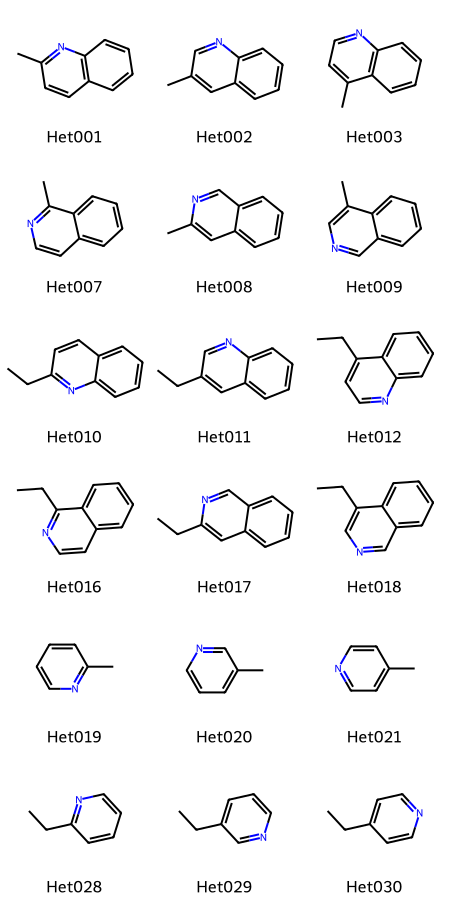

Processing pyrmd with molecules ['Het004', 'Het005', 'Het013', 'Het014', 'Het022', 'Het023', 'Het024', 'Het031', 'Het032', 'Het033']


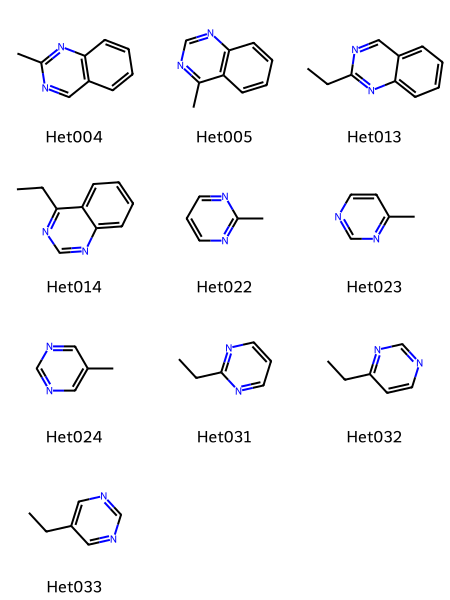

Processing pyrz with molecules ['Het006', 'Het015', 'Het025', 'Het034']


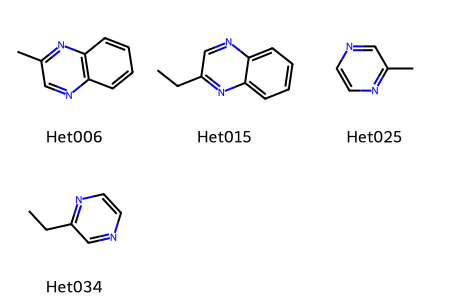

Processing pyrdz with molecules ['Het026', 'Het027', 'Het035']


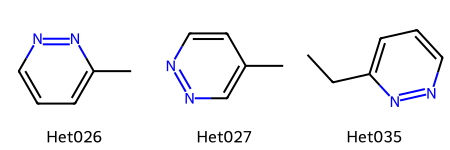

In [14]:
# display the molecules in a grid images group by the imverse_mapping key
for key, value in inverse_mapping.items():
    # get the molecules name
    print(f"Processing {key} with molecules {value}")
    mols_ = [mols[id] for id in value]
    legends_ = value
    
    # Generate a grid image with a fixed number of columns (4 columns)
    img = Chem.Draw.MolsToGridImage(
        mols_, molsPerRow=3, subImgSize=(150, 150), legends=legends_
    )
    # Display the grid of images
    display(img)

In [15]:
# output this to json
import json

with open("name_mapping.json", "w") as f:
    json.dump(final_mapping, f, sort_keys=True, indent=4)